## Install and Import

In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 10000)
pd.set_option('display.max_colwidth', None)

## Data investigating

In [2]:
data = pd.read_excel("LAEI2013_Emissions_Summary-CO2_v1.1_Clean.xlsx",skiprows=0,sheet_name="IN")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10065 entries, 0 to 10064
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   year                    10065 non-null  int64  
 1   borough                 10065 non-null  int64  
 2   zone                    10065 non-null  int64  
 3   landfill                10065 non-null  float64
 4   nrmm_construction       10065 non-null  float64
 5   nrmm_industry           10065 non-null  float64
 6   domestic_gas            10065 non-null  float64
 7   commercial_gas          10065 non-null  float64
 8   domestic_other_fuels    10065 non-null  float64
 9   commercial_other_fuels  10065 non-null  float64
 10  industry_part_a         10065 non-null  float64
 11  industry_part_b         10065 non-null  float64
 12  aviation                10065 non-null  float64
 13  passenger_shipping      10065 non-null  float64
 14  commercial_shipping     10065 non-null

In [3]:
data.head()

,year,borough,zone,landfill,nrmm_construction,nrmm_industry,domestic_gas,commercial_gas,domestic_other_fuels,commercial_other_fuels,industry_part_a,industry_part_b,aviation,passenger_shipping,commercial_shipping,rail_freight,rail_passengers,motorcycle,taxi,petrol_car,diesel_car,petrol_lgv,diesel_lgv,tfl_bus,non-tfl_bus_and_coach,artic_hgv,rigid_hgv,total
0,2008,26,2,40.299208,0.0,29.037647,169.896525,267.599694,34.661398,225.726463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.794446,0.729308,65.296798,28.201613,0.530240,11.047829,0.976673,3.437355,1.056543,6.777960,886.069700
1,2008,26,2,0.000000,0.0,16.445759,91.442445,311.594175,20.145096,276.459214,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46.059539,75.319727,4813.802423,2779.411657,82.955116,1515.757059,30.338328,193.357560,2591.992620,1153.954988,13999.035705
2,2008,26,2,0.000000,0.0,77.735009,253.379851,311.591604,19.937190,276.456934,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.434101,34.094676,2188.666090,1398.219593,44.999390,721.108900,5.993533,79.087914,1899.210830,620.269635,7950.185250
3,2008,26,2,10152.007346,0.0,19.704125,980.361642,320.748184,6.243711,276.459214,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.792363,0.727326,65.081353,28.108563,0.528477,11.011090,0.973637,3.426670,1.049198,6.755514,11873.978414
4,2008,26,2,3513.850389,0.0,1.028658,1122.054950,505.360236,9.088597,276.456934,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.714850,0.656304,58.761915,25.379204,0.477185,9.942397,0.878163,3.090653,0.948943,6.099634,5534.789011


In [4]:
# Descriptive statistics of the 'total' column to understand its distribution and scale
total_descriptive_stats = data['total'].describe()
total_descriptive_stats

count    1.006500e+04
mean     9.685670e+03
std      3.804064e+04
min      5.620224e-02
25%      1.766579e+03
50%      6.328637e+03
75%      1.241446e+04
max      2.312328e+06
Name: total, dtype: float64

In [5]:
# Count: There are 10,065 observations in the total column.
# Mean: The average value of total emissions is approximately 9,685.67.
# Standard Deviation: A high standard deviation of 38,040.64, indicating significant variability in 
# the data.
# Minimum: The smallest value is about 0.056, which is very close to zero.
# 25% Quantile: 25% of the data is below 1,766.58, which shows a modest level of emissions.
# Median (50% Quantile): The median value is 6,328.64, suggesting that half of the data points are 
# below this value and half are above.
# 75% Quantile: 75% of the data is below 12,414.46, indicating that most data points are relatively 
# moderate in size.
# Maximum: The maximum value is extremely high at about 2,312,328, which is significantly larger than
# the 75% quantile.

# Key Insights:
# Wide Range of Values: The total emissions values range from near zero to over two million, which is 
# a massive range. This wide range impacts the MSE because errors in predictions of higher values are
# squared, leading to much larger mean squared errors.
# Presence of Outliers: The maximum value suggests the presence of extreme outliers. These outliers 
# can disproportionately affect the MSE, as large deviations from the mean (especially as squared 
# values) contribute significantly to the overall error metric.
# High Variability: The large standard deviation relative to the mean indicates high variability in 
# the emissions data, which can make accurate prediction challenging and affect the MSE.

## Prepare Data

In [6]:
feature_columns = data.columns.drop('total')

In [7]:
# Split 2013 data into training and testing
test_data_2013, train_data_2013 = train_test_split(data[data['year'] == 2013], test_size=0.5, random_state=42)

In [8]:
# Combine non-2013 data with part of 2013 training data
remaining_data = data[data['year'] != 2013]
new_train_data = pd.concat([remaining_data, train_data_2013])

In [9]:
# Split the new combined data into training and validation sets
X_train, X_validate, y_train, y_validate = train_test_split(
    new_train_data[feature_columns],
    new_train_data['total'],
    train_size=0.8,  # 80% for training, 20% for validation
    random_state=42
)

In [10]:
# prepare test datasets
X_test = test_data_2013[feature_columns]
y_test = test_data_2013['total']

## Random Forest

In [11]:
# Initialize the Random Forest Regressor
# n_estimators: This parameter specifies the number of trees that the algorithm will build before
# taking the maximum voting or averages of predictions. In general, a higher number of trees gives
# you better performance but also makes your code slower. Each tree in the ensemble is built from
# a random sample of the data.
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [13]:
# Validate the model
y_pred_validate = rf_regressor.predict(X_validate)

In [14]:
# Evaluate the validation performance
r2_validate = r2_score(y_validate, y_pred_validate)
mse_validate = mean_squared_error(y_validate, y_pred_validate)

In [15]:
# Test the model using the designated test set
y_pred_test = rf_regressor.predict(X_test)

In [16]:
# Evaluate the test performance
r2_test = r2_score(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)

In [17]:
# Output results
print(f'Validation R^2: {r2_validate}, MSE: {mse_validate}')
print(f'Test R^2: {r2_test}, MSE: {mse_test}')

Validation R^2: 0.9296142544200079, MSE: 39881874.74674371
Test R^2: 0.9683002307873028, MSE: 10727332.91166468


## XGBoost Regressor

In [18]:
# Initialize the XGBoost Regressor
xgb_regressor = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)


In [19]:
# Train the model
xgb_regressor.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [20]:
# Validate the model
y_pred_validate = xgb_regressor.predict(X_validate)

In [21]:
# Evaluate the validation performance
r2_validate = r2_score(y_validate, y_pred_validate)
mse_validate = mean_squared_error(y_validate, y_pred_validate)

In [22]:
# Test the model using the designated test set
y_pred_test = xgb_regressor.predict(X_test)

In [23]:
# Evaluate the test performance
r2_test = r2_score(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)

In [24]:
# Output results
print(f'Validation R^2: {r2_validate}, MSE: {mse_validate}')
print(f'Test R^2: {r2_test}, MSE: {mse_test}')

Validation R^2: 0.9910485062060836, MSE: 5072083.15182935
Test R^2: 0.9708919528562598, MSE: 9850283.452355828


## SVM

In [11]:
# Scaling the data
# scaling the data using StandardScaler and fitting only on the training data before transforming all
# datasets to ensure that SVR performs optimally and that evaluation 
# metrics are consistent and reliable across train, test, and validation sets. 

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_validate_scaled = scaler.transform(X_validate)

In [26]:
# Parameter grid for SVR
param_grid = {
    'kernel': ['linear', 'poly', 'rbf'],
    'C': [0.1, 1, 5],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],  
    'epsilon': [0.01, 0.1, 1],
    'degree': [2, 3, 4]  # Only needed for 'poly'
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(SVR(), param_grid, cv=5, scoring='r2', verbose=10)

In [27]:
# Fit GridSearchCV to the data
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 405 candidates, totalling 2025 fits
[CV 1/5; 1/405] START C=0.1, degree=2, epsilon=0.01, gamma=scale, kernel=linear.
[CV 1/5; 1/405] END C=0.1, degree=2, epsilon=0.01, gamma=scale, kernel=linear;, score=0.216 total time=   0.6s
[CV 2/5; 1/405] START C=0.1, degree=2, epsilon=0.01, gamma=scale, kernel=linear.
[CV 2/5; 1/405] END C=0.1, degree=2, epsilon=0.01, gamma=scale, kernel=linear;, score=0.069 total time=   0.6s
[CV 3/5; 1/405] START C=0.1, degree=2, epsilon=0.01, gamma=scale, kernel=linear.
[CV 3/5; 1/405] END C=0.1, degree=2, epsilon=0.01, gamma=scale, kernel=linear;, score=0.079 total time=   0.6s
[CV 4/5; 1/405] START C=0.1, degree=2, epsilon=0.01, gamma=scale, kernel=linear.
[CV 4/5; 1/405] END C=0.1, degree=2, epsilon=0.01, gamma=scale, kernel=linear;, score=0.164 total time=   0.6s
[CV 5/5; 1/405] START C=0.1, degree=2, epsilon=0.01, gamma=scale, kernel=linear.
[CV 5/5; 1/405] END C=0.1, degree=2, epsilon=0.01, gamma=scale, kernel=linear;, score=0

GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [0.1, 1, 5], 'degree': [2, 3, 4],
                         'epsilon': [0.01, 0.1, 1],
                         'gamma': ['scale', 'auto', 0.01, 0.1, 1],
                         'kernel': ['linear', 'poly', 'rbf']},
             scoring='r2', verbose=10)

In [12]:
# Best model from GridSearch
best_svr = grid_search.best_estimator_

# Display the best model parameters
print("Best model parameters:", grid_search.best_params_)

# Validate the model
y_pred_validate = best_svr.predict(X_validate_scaled)

# Evaluate the validation performance
r2_validate = r2_score(y_validate, y_pred_validate)
mse_validate = mean_squared_error(y_validate, y_pred_validate)

# Test the model using the designated test set
y_pred_test = best_svr.predict(X_test_scaled)

# Evaluate the test performance
r2_test = r2_score(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)

# Output results
print(f"Validation R^2: {r2_validate:.4f}, MSE: {mse_validate:.2f}")
print(f"Test R^2: {r2_test:.4f}, MSE: {mse_test:.2f}")

Validation R^2: 0.6482, MSE: 199315691.71
Test R^2: 0.5608, MSE: 148633778.00


In [30]:
# Extract configurations with R^2 > 0.8 from GridSearchCV results
results = pd.DataFrame(grid_search.cv_results_)
high_score_configs = results[results['mean_test_score'] > 0.8]

# Print high score configurations
print("Configurations with mean CV R^2 > 0.8:")
display(high_score_configs[['param_C', 'param_degree', 'param_epsilon', 'param_gamma', 'param_kernel', 'mean_test_score']])


Configurations with mean CV R^2 > 0.8:


,param_C,param_degree,param_epsilon,param_gamma,param_kernel,mean_test_score


In [31]:
# Select configurations to retest on validation data
selected_params = high_score_configs[['param_C', 'param_degree', 'param_epsilon', 'param_gamma', 'param_kernel']]

# Iterate over the selected configurations
for _, row in selected_params.iterrows():
    config = row.to_dict()
    config = {k.split('param_')[-1]: v for k, v in config.items()}  # Clean keys
    
    print(f"\nTraining SVM with config: {config}")
    
    # Initialize and train the SVM model
    svm_model = SVR(**config)
    svm_model.fit(X_train_scaled, y_train)
    
    # Validate the model
    y_pred_validate = svm_model.predict(X_validate_scaled)
    
    # Evaluate the validation performance
    r2_validate = r2_score(y_validate, y_pred_validate)
    mse_validate = mean_squared_error(y_validate, y_pred_validate)
    
    # Test the model using the designated test set
    y_pred_test = svm_model.predict(X_test_scaled)
    
    # Evaluate the test performance
    r2_test = r2_score(y_test, y_pred_test)
    mse_test = mean_squared_error(y_test, y_pred_test)
    
    # Output results
    print(f"Validation R^2: {r2_validate:.4f}, MSE: {mse_validate:.2f}")
    print(f"Test R^2: {r2_test:.4f}, MSE: {mse_test:.2f}")

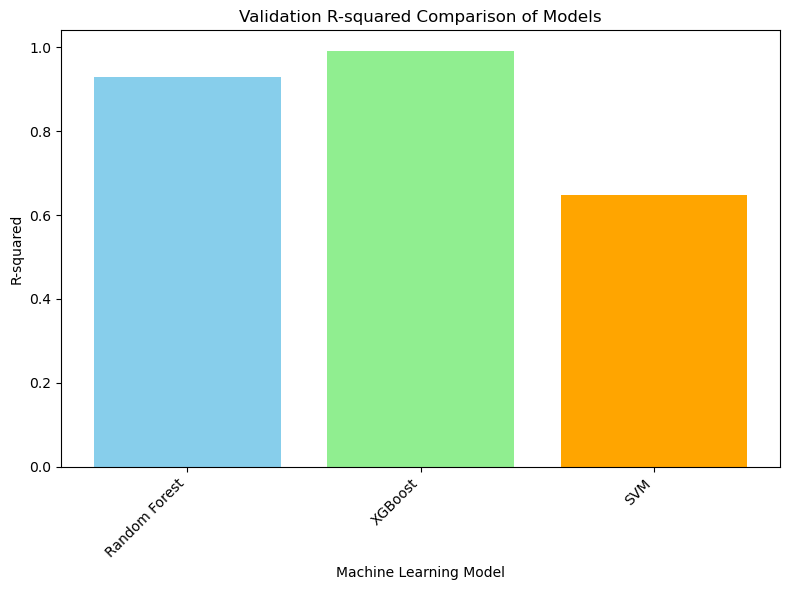

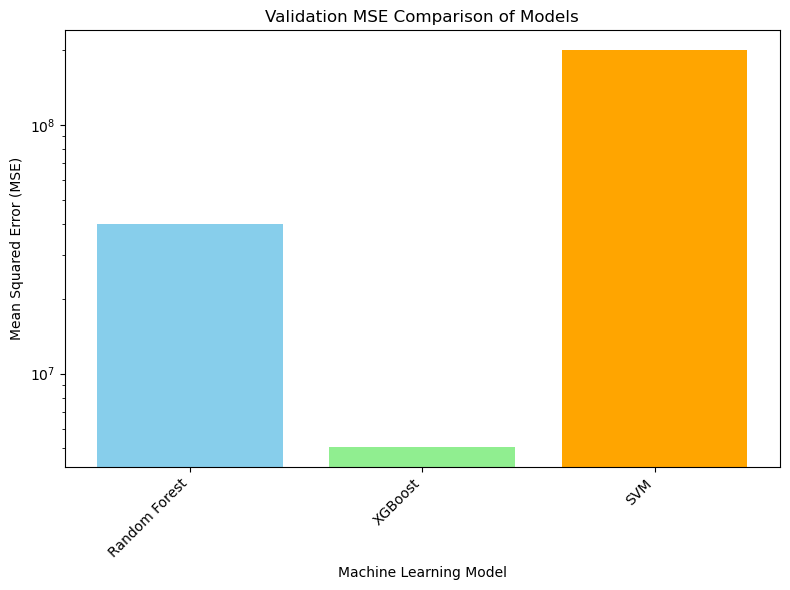

In [19]:
# Model names and their corresponding R-squared and MSE values
models = ["Random Forest", "XGBoost", "SVM"]
r_squared = [0.9296, 0.9910, 0.6482]
mse = [39881874.7467, 5072083.1518, 199315691.71]

# Create the bar chart for R-squared values
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))  # Adjust figure size as needed

plt.bar(models, r_squared, color=['skyblue', 'lightgreen', 'orange'])
plt.xlabel("Machine Learning Model")
plt.ylabel("R-squared")
plt.title("Validation R-squared Comparison of Models")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability

plt.tight_layout()
plt.show()

# Create the bar chart for MSE values
plt.figure(figsize=(8, 6))  # Adjust figure size as needed

plt.bar(models, mse, color=['skyblue', 'lightgreen', 'orange'])
plt.xlabel("Machine Learning Model")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Validation MSE Comparison of Models")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.yscale("log")  # Use log scale for better visualization of large MSE values

plt.tight_layout()
plt.show()


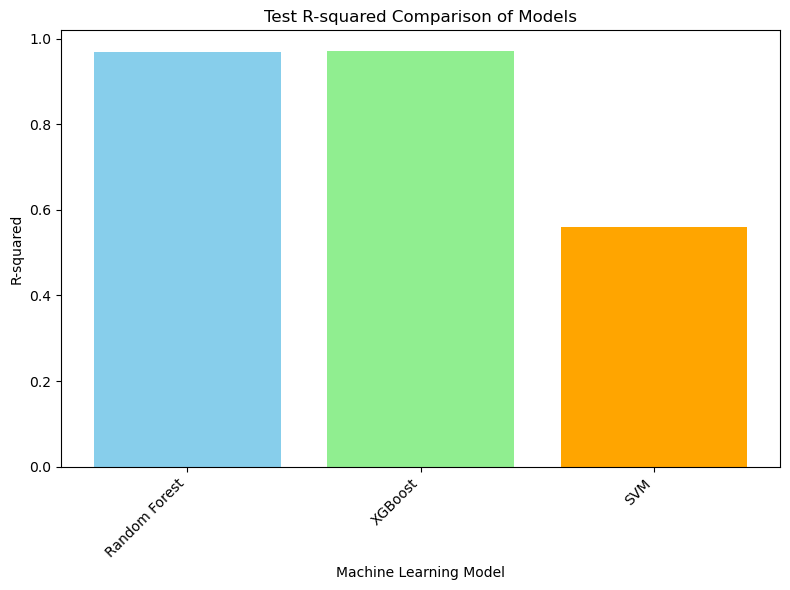

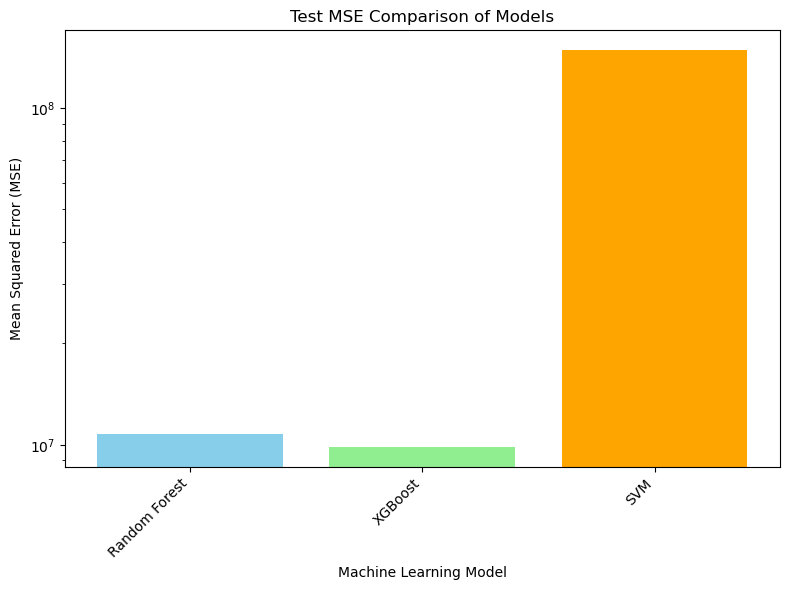

In [18]:
# Model names and their corresponding R-squared and MSE values
models = ["Random Forest", "XGBoost", "SVM"]
r_squared = [0.9683, 0.9708, 0.5608]
mse = [10727332.9116, 9850283.4523, 148633778.00]

# Create the bar chart for R-squared values
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))  # Adjust figure size as needed

plt.bar(models, r_squared, color=['skyblue', 'lightgreen', 'orange'])
plt.xlabel("Machine Learning Model")
plt.ylabel("R-squared")
plt.title("Test R-squared Comparison of Models")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability

plt.tight_layout()
plt.show()

# Create the bar chart for MSE values
plt.figure(figsize=(8, 6))  # Adjust figure size as needed

plt.bar(models, mse, color=['skyblue', 'lightgreen', 'orange'])
plt.xlabel("Machine Learning Model")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Test MSE Comparison of Models")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.yscale("log")  # Use log scale for better visualization of large MSE values

plt.tight_layout()
plt.show()

## Notes

In [32]:
# For predicting atmospheric emissions, the choice of algorithms depends on the nature of the problem
# and the data. Here are three machine learning algorithms that will use for this project, 
# along with the rationale for choosing them:

# 1. Random Forest Regression
# This ensemble learning method combines multiple decision trees to create a more robust and accurate
# model. It's well-suited for regression problems with complex, non-linear relationships. 
# Given that atmospheric emissions data likely contain a mix of categorical and continuous variables,
# along with potential interactions among them, Random Forest can handle these complexities effectively.

# 2.Gradient Boosting Regression(XGBoost)
# Like Random Forest, Gradient Boosting combines multiple weak learners (decision trees) to create a 
# strong predictive model. However, it does so in a sequential manner, learning from the errors of 
# previous trees. This approach can be effective for data with many features and complex relationships,
# and often yields high accuracy. XGBoost is a popular choice for its efficiency and robustness.

# 3.Support Vector Machines(SVM)
# This method is useful for both classification and regression tasks. It constructs hyperplanes in
# high-dimensional space to separate different classes or predict a continuous target.
# SVM is robust to outliers and can work with complex datasets. For atmospheric emissions data, 
# SVM can be used to identify patterns and relationships that might not be immediately apparent.

In [33]:
# When evaluating regression models, two common metrics used to assess their performance are
# R-squared (R²) and Mean Squared Error (MSE). Both provide valuable information about how well 
# the model fits the data, but they tell us slightly different things about the model's performance.

# R-squared (R²)
# R-squared, also known as the coefficient of determination, is a statistical measure that represents
# the proportion of the variance for the dependent variable (i.e., target variable total in this
# case) that's predicted from the independent variables (features). It is essentially a measure of how
# close the observed data points are to the model's predicted values.
# Value Range: R-squared ranges from 0 to 1, where 0 means that the model does not explain any of the 
# variability of the response data around its mean, and 1 means it explains all the variability.
# Interpretation: A high R-squared is generally better, though it does not necessarily mean the model is good — it 
# could also indicate overfitting, especially if the test data R-squared is significantly lower.

# Mean Squared Error (MSE)
# Mean Squared Error is the average of the squares of the errors—that is, the average squared 
# difference between the estimated values and the actual value. MSE is a risk metric corresponding to
# the expected value of the squared (quadratic) error loss.
# Value: Unlike R-squared, MSE can range from zero to infinity. A value of zero indicates perfect 
# predictions (no error), and higher values indicate worse performance.
# Interpretation:A lower MSE is always better as it indicates that the predictions are closer to the
# actual data. 

# Contextual Comparison
# Validation R² vs. MSE: While R-squared provides a scaled measure of fit quality relative to the 
# variance of the data, MSE provides an absolute measure that reflects the average error magnitude
# in the same units as the predicted variable. This makes MSE especially useful in cases where needed\
# to have an idea of the error magnitude in its original context.
# Model Decision: Deciding on the model often involves a trade-off between these metrics. For instance,
# a model might have a very high R-squared but also a high MSE if the errors, though few, are very large
# when they occur.

In [34]:
# Comparison with Random Forest Performance
# Improved Performance with XGBoost, the XGBoost model generally performs better in both the 
# validation and testing phases compared to the Random Forest model. The higher R-squared values for
# XGBoost indicate a better fit to the data, possibly due to more effective handling of the underlying
# patterns and relationships among the features.
# Although the MSE for XGBoost on the validation set is significantly lower than Random Forest, 
# the test MSE for XGBoost is lower than the Random Forest model. This suggests that XGBoost, while 
# being very accurate on unseen data (validation set), might be slightly less robust to the specific
# characteristics of the test set used or could be beginning to overfit despite the high R-squared 
# value.
# XGBoost provides a very high level of accuracy and is potentially a more powerful tool for this
# dataset, particularly when accuracy is critical, and the range of prediction errors 
# (as indicated by MSE) is acceptable. However, the choice between Random Forest and XGBoost might 
# also consider factors like model training and prediction time, interpretability, and how each model
# handles overfitting with parameter tuning.
# 
# Comparison with SVM (Support Vector Machine)
# The SVM model, optimized with GridSearchCV to fine-tune various hyperparameters across different kernels, 
# was applied. This optimization led to varying validation R² and MSE values, # and different test R² with MSE. 
# These results indicate that the model explains a significant portion of the variance, 
# but still with substantial error magnitudes. The kernels effectively model non-linear relationships, 
# which is crucial for handling complex environmental data. However, even with GridSearchCV streamlining 
# the search for optimal parameters, the process remains computationally intensive and time-consuming.
# 
# Despite achieving reasonable predictive performance, the SVM models exhibit a slight drop from validation to test R², 
# suggesting potential overfitting or mismatches in data distribution. This could indicate that while the 
# model is finely tuned to the training data, it may not generalize as well to unseen data.
# 
# In contrast, ensemble methods like Random Forest and XGBoost often provide improved accuracy and better generalization, 
# with less computational demand compared to SVM. These methods benefit from multiple decision trees to reduce variance
# and bias, which helps in tackling overfitting more effectively than a single SVM model. Thus, while SVM provides a 
# robust approach for modeling complex, non-linear relationships in data, ensemble methods remain a good alternative 
# for achieving higher predictive accuracy and robustness with lower computational overhead.
